In [25]:
import numpy as np
import qiskit as q
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

Алгоритм Дойча - Йожи - константный оракул:

Deutsch-Josza Circuit:


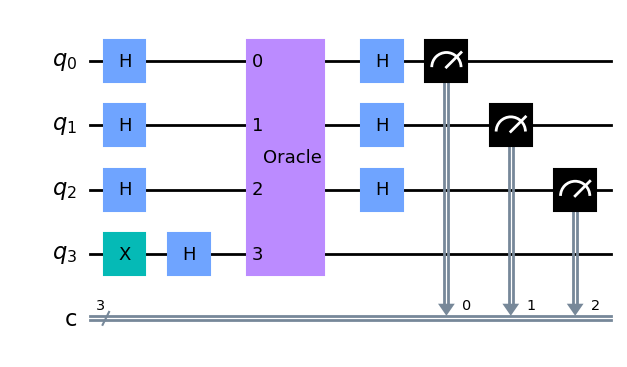

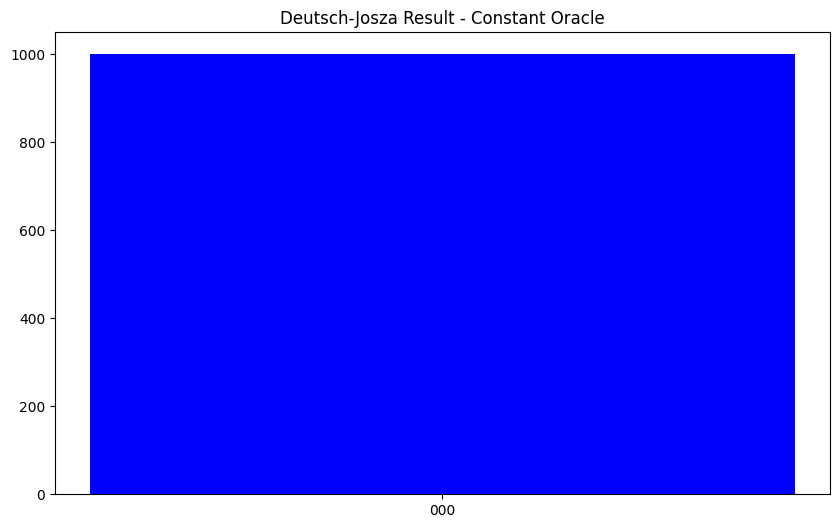

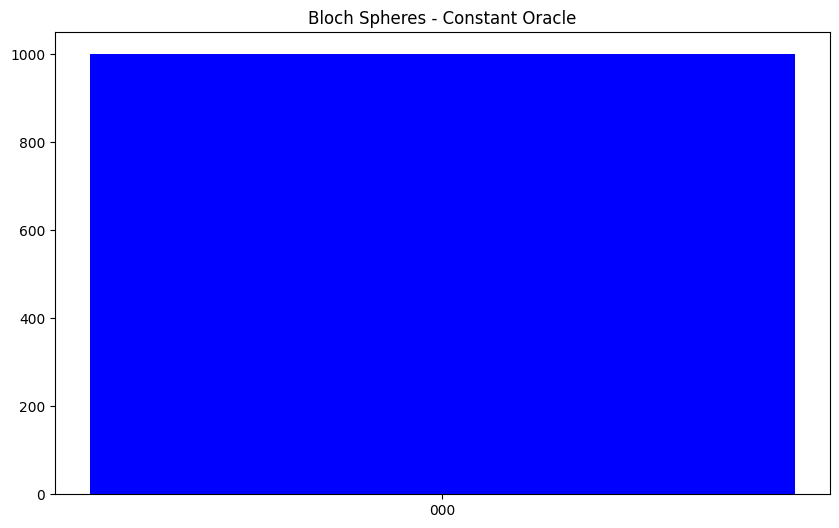


Алгоритм Дойча - Йожи - сбалансированный оракул:

Deutsch-Josza Circuit:


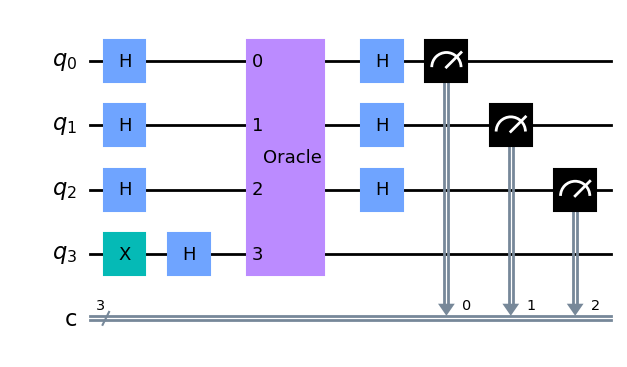

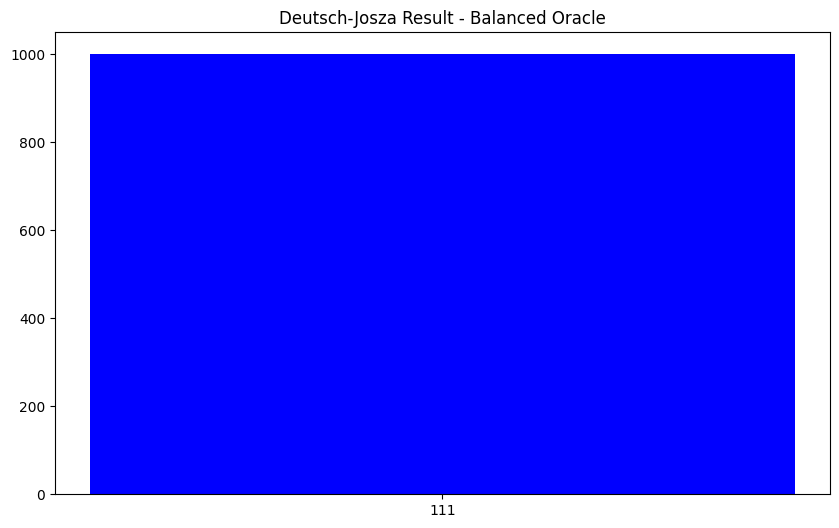

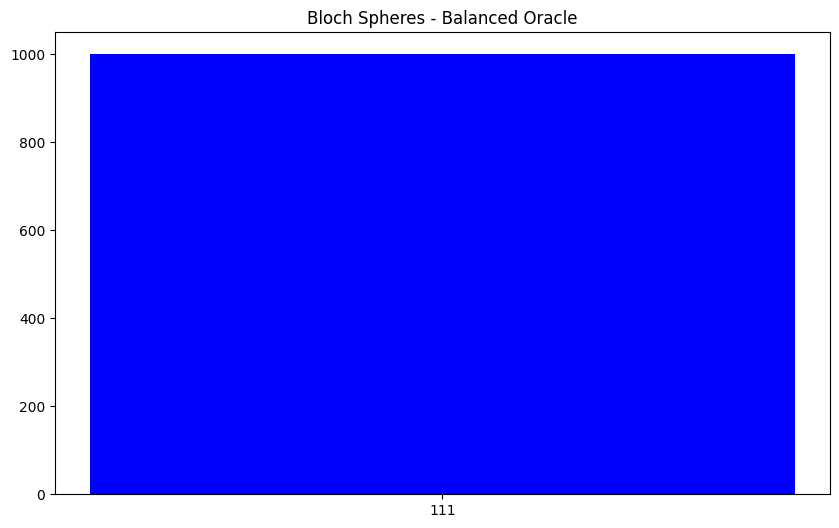

In [26]:
# Функция, создающая оракул для алгоритма Дойча-Йожи
# Входные параметры: case - тип оракула ("balanced" или "constant"), num_qubits - количество кубитов
def dj_oracle(case: str, num_qubits: int) -> q.QuantumCircuit:
    oracle_qc = q.QuantumCircuit(num_qubits + 1)  # Создаем квантовую схему с дополнительным кубитом для результата

    # Реализация сбалансированного оракула
    if case == "balanced":
        b = np.random.randint(0, 2**num_qubits)  # Генерация случайного числа от 0 до 2^num_qubits - 1
        b_str = format(b, f"0{num_qubits}b")  # Преобразование в двоичную строку

        # Применение оператора X (NOT) к кубитам в зависимости от значения b_str
        for index, bit in enumerate(b_str):
            if bit == "1":
                oracle_qc.x(index)

        # Применение CNOT-гейтов для реализации сбалансированного поведения
        for index in range(num_qubits):
            oracle_qc.cx(index, num_qubits)  # Применяем CNOT, связывающий входные кубиты с выходным кубитом

        # Восстановление исходного состояния для кубитов
        for index, bit in enumerate(b_str):
            if bit == "1":
                oracle_qc.x(index)

    # Реализация константного оракула
    elif case == "constant":
        output = np.random.randint(2)  # Генерация случайного значения (0 или 1)
        if output == 1:
            oracle_qc.x(num_qubits)  # Применение X-гейта к выходному кубиту для результата 1

    # Преобразование схемы оракула в "гейт"
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"  # Назначаем имя для гейта
    return oracle_gate

# Основная функция для алгоритма Дойча-Йожи
# Входные параметры: oracle - оракул в виде квантовой схемы, num_qubits - количество кубитов
def dj_algorithm(oracle: q.QuantumCircuit, num_qubits: int) -> q.QuantumCircuit:
    dj_circuit = q.QuantumCircuit(num_qubits + 1, num_qubits)  # Создаем схему с регистром для классических результатов

    # Начальная настройка: установка вспомогательного кубита в состояние |1⟩ и наложение на остальные кубиты
    dj_circuit.x(num_qubits)
    dj_circuit.h(num_qubits)

    for qubit in range(num_qubits):
        dj_circuit.h(qubit)

    # Применение оракула
    dj_circuit.append(oracle, range(num_qubits + 1))

    # Применение гейтов Адамара для преобразования в нужное состояние
    for qubit in range(num_qubits):
        dj_circuit.h(qubit)

    # Измерение кубитов для получения результата
    for i in range(num_qubits):
        dj_circuit.measure(i, i)

    return dj_circuit

# Функция для выполнения алгоритма Дойча-Йожи и визуализации результатов
# Входные параметры: case - тип оракула ("balanced" или "constant"), num_qubits - количество кубитов
def deutsch_jozsa(case: str, num_qubits: int):
    simulator = q.Aer.get_backend("qasm_simulator")  # Инициализация симулятора для выполнения схемы
    oracle_gate = dj_oracle(case, num_qubits)  # Генерация оракула
    dj_circuit = dj_algorithm(oracle_gate, num_qubits)  # Создание основной схемы алгоритма

    # Отображение квантовой схемы
    print("\nDeutsch-Josza Circuit:")
    display(dj_circuit.draw(output="mpl"))

    # Выполнение схемы и получение результатов
    job = q.execute(dj_circuit, simulator, shots=1000)
    result_counts = job.result().get_counts(dj_circuit)
    labels = list(result_counts.keys())
    values = list(result_counts.values())

    # Построение гистограммы с результатами
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange'])
    plot_histogram(result_counts)
    plt.title(f"Deutsch-Josza Result - {case.capitalize()} Oracle")
    plt.show()

    # Опционально: отображение сфер Блоха для каждого кубита после выполнения алгоритма
    statevector_simulator = q.Aer.get_backend("statevector_simulator")
    job_sv = q.execute(dj_circuit, statevector_simulator)
    statevector = job_sv.result().get_statevector()
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange'])
    plot_bloch_multivector(statevector)
    plt.title(f"Bloch Spheres - {case.capitalize()} Oracle")
    plt.show()

    return result_counts

# Основная часть программы для запуска алгоритма Дойча-Йожи
if __name__ == "__main__":
    # Запуск для константного оракула
    print(f"Алгоритм Дойча - Йожи - константный оракул:")
    deutsch_jozsa('constant', 3)

    # Запуск для сбалансированного оракула
    print(f"\nАлгоритм Дойча - Йожи - сбалансированный оракул:")
    deutsch_jozsa('balanced', 3)
